In [1]:
import torch
import random
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained(
    'processor/facebook/detr-resnet-50',
    size={
        'longest_edge': 800,
        'shortest_edge': 800
    })

processor

/root/miniconda3/envs/pt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DetrImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 800,
    "shortest_edge": 800
  }
}

In [2]:
from datasets import load_from_disk

dataset = load_from_disk('dataset/lansinuote/ocr_id_card_small')['train']

def f(data):
    box = [i['box'] for i in data['ocr']]
    cls = [i['cls'] for i in data['ocr']]
    return {'image': data['image'], 'box': box, 'cls': cls}

dataset = dataset.map(f, remove_columns=['ocr'])

dataset, dataset[0]

(Dataset({
     features: ['image', 'box', 'cls'],
     num_rows: 8500
 }),
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=250x250>,
  'box': [[49.713941536006374,
    31.017112564616305,
    84.34739644797423,
    56.823359827267545],
   [48.396413600453215,
    60.27906174757388,
    62.12991846361899,
    85.03621709441235],
   [95.53531805083459,
    65.27309398461871,
    109.2688229140004,
    90.03024933145721],
   [47.28158227036977,
    91.88196686516804,
    71.98526505536066,
    111.97578766994951],
   [88.4345940921313,
    96.24183627846115,
    97.42530872699506,
    114.67097967089434],
   [104.89579882083592,
    97.9857840437784,
    118.37593292716456,
    116.89054955402537],
   [45.00124545883547,
    119.9734380808073,
    136.61390433736082,
    171.6230872605421],
   [71.85146106045553,
    199.14604972228662,
    169.98367684877454,
    229.34932105266336]],
  'cls': [0, 1, 2, 3, 4, 5, 6, 7]})

In [3]:
def f(data):
    image = [i['image'].convert('RGB') for i in data]
    box = [i['box'] for i in data]
    cls = [i['cls'] for i in data]

    annotations = []
    for bs, cs in zip(box, cls):
        for b in bs:
            b[2] -= b[0]
            b[3] -= b[1]
        anno = [{
            'category_id': c,
            'area': 0,
            'bbox': b
        } for b, c in zip(bs, cs)]
        annotations.append({'image_id': 0, 'annotations': anno})

    data = processor(image, annotations=annotations, return_tensors='pt')

    pixel_values = data['pixel_values'].to('cuda')
    pixel_mask = data['pixel_mask'].to('cuda')

    size = []
    class_target = []
    box_target = []
    for label in data['labels']:
        size.append(label['size'].tolist())
        class_target.append(label['class_labels'].to('cuda'))
        box_target.append(label['boxes'].to('cuda'))

    return pixel_values, pixel_mask, class_target, box_target, size


loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=8,
                                     shuffle=True,
                                     drop_last=True,
                                     collate_fn=f)

pixel_values, pixel_mask, class_target, box_target, size = next(iter(loader))

print(len(loader))
print(size)

pixel_values.shape, pixel_mask.shape, class_target[0], box_target[0]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


1062
[[800, 800], [800, 800], [800, 800], [800, 800], [800, 800], [800, 800], [800, 800], [800, 800]]


(torch.Size([8, 3, 800, 800]),
 torch.Size([8, 800, 800]),
 tensor([0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0'),
 tensor([[0.3166, 0.3810, 0.0852, 0.0575],
         [0.2926, 0.4527, 0.0332, 0.0569],
         [0.4097, 0.4452, 0.0332, 0.0569],
         [0.3085, 0.5190, 0.0607, 0.0450],
         [0.3913, 0.5137, 0.0217, 0.0425],
         [0.4433, 0.5104, 0.0217, 0.0425],
         [0.3931, 0.6085, 0.2260, 0.1131],
         [0.4794, 0.7556, 0.2431, 0.0622]], device='cuda:0'))

In [4]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()

        from transformers import DetrModel, DetrConfig
        config = DetrConfig.from_pretrained('model/facebook/detr-resnet-50')
        self.model = DetrModel(config)
        self.class_labels_classifier = torch.nn.Linear(256, 92)

        self.bbox_predictor = torch.nn.Sequential(torch.nn.Linear(256, 256),
                                                  torch.nn.ReLU(),
                                                  torch.nn.Linear(256, 256),
                                                  torch.nn.ReLU(),
                                                  torch.nn.Linear(256, 4))

        #加载参数
        from transformers import AutoModelForObjectDetection
        parameters = AutoModelForObjectDetection.from_pretrained(
            'model/facebook/detr-resnet-50', ignore_mismatched_sizes=True)

        self.model.load_state_dict(parameters.model.state_dict())

        self.class_labels_classifier.load_state_dict(
            parameters.class_labels_classifier.state_dict())

        self.bbox_predictor[0].load_state_dict(
            parameters.bbox_predictor.layers[0].state_dict())

        self.bbox_predictor[2].load_state_dict(
            parameters.bbox_predictor.layers[1].state_dict())

        self.bbox_predictor[4].load_state_dict(
            parameters.bbox_predictor.layers[2].state_dict())

        del parameters

        self.to('cuda')
        self.train()

    def forward(self, pixel_values, pixel_mask):
        last_hidden_state = self.model(pixel_values=pixel_values,
                                       pixel_mask=pixel_mask).last_hidden_state

        class_pred = self.class_labels_classifier(last_hidden_state)
        box_pred = self.bbox_predictor(last_hidden_state).sigmoid()

        return class_pred, box_pred


model = Model()

with torch.no_grad():
    class_pred, box_pred = model(pixel_values, pixel_mask)

class_pred.shape, box_pred.shape

(torch.Size([8, 100, 92]), torch.Size([8, 100, 4]))

In [5]:
%run 2.文字定位Loss函数.ipynb

criterion.to('cuda')

DetrLoss()

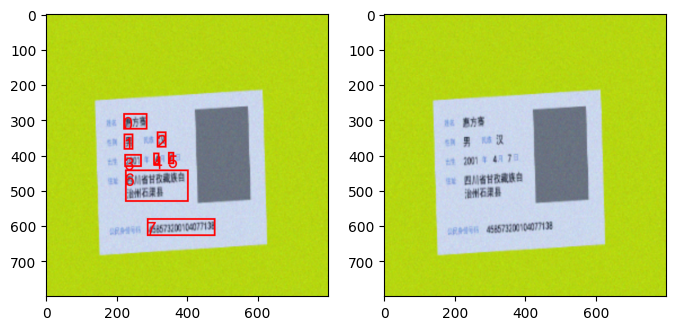

In [6]:
import PIL.ImageDraw
import PIL.ImageFont
from matplotlib import pyplot as plt
import numpy as np


def show(image, box_target, class_target, box_pred, class_pred, size):
    font = PIL.ImageFont.truetype('arial.ttf', size=50)

    image = image - image.min()
    image = image / image.max() * 255
    image = image.permute(1, 2, 0)
    image = np.uint8(image.to('cpu').numpy())
    image = PIL.Image.fromarray(image, 'RGB')

    box_target = matcher.xywh_to_x1y1x2y2(box_target)
    box_target[:, 0] *= size[1]
    box_target[:, 1] *= size[0]
    box_target[:, 2] *= size[1]
    box_target[:, 3] *= size[0]

    image_target = image.copy()
    draw = PIL.ImageDraw.Draw(image_target)
    for b, c in zip(box_target, class_target.tolist()):
        draw.rectangle(b.tolist(), outline='red', width=5)
        draw.text(b.tolist()[:2], str(c), fill='red', font=font)

    class_pred = class_pred.argmax(1)
    box_pred = box_pred[class_pred <= 7]
    class_pred = class_pred[class_pred <= 7]
    box_pred = matcher.xywh_to_x1y1x2y2(box_pred)
    box_pred[:, 0] *= size[1]
    box_pred[:, 1] *= size[0]
    box_pred[:, 2] *= size[1]
    box_pred[:, 3] *= size[0]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_target)

    image_pred = image.copy()
    draw = PIL.ImageDraw.Draw(image_pred)
    for b, c in zip(box_pred, class_pred.tolist()):
        draw.rectangle(b.tolist(), outline='red', width=5)
        draw.text(b.tolist()[:2], str(c), fill='red', font=font)

    plt.subplot(1, 2, 2)
    plt.imshow(image_pred)
    plt.show()


show(pixel_values[0], box_target[0], class_target[0], box_pred[0],
     class_pred[0], size[0])

0 0 11.446269989013672


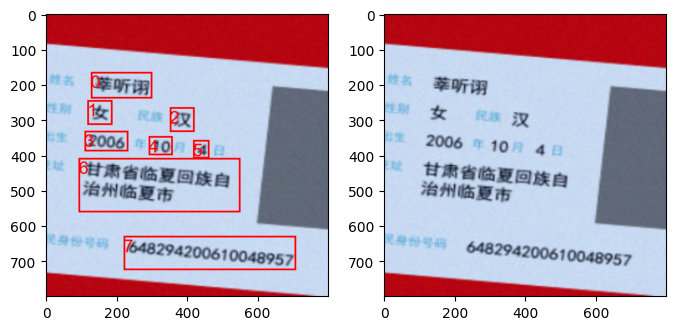

0 500 0.45243680477142334


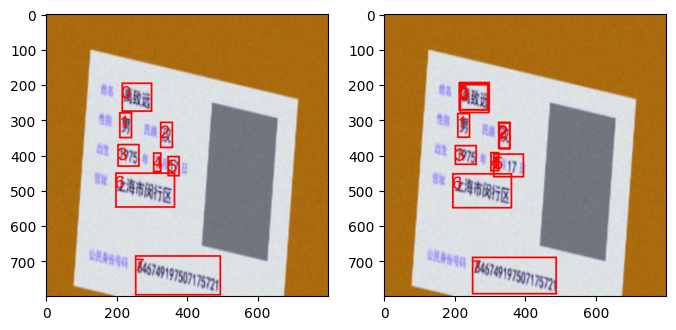

0 1000 0.2975529432296753


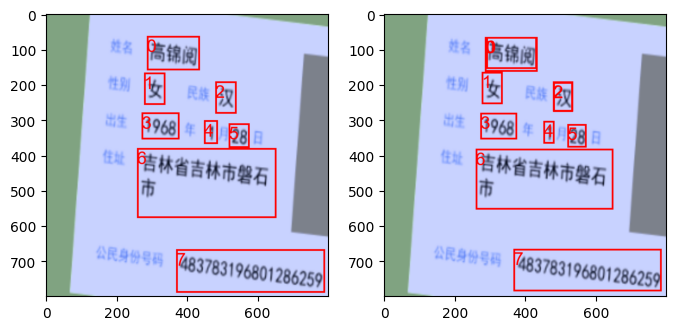

1 0 0.2717714309692383


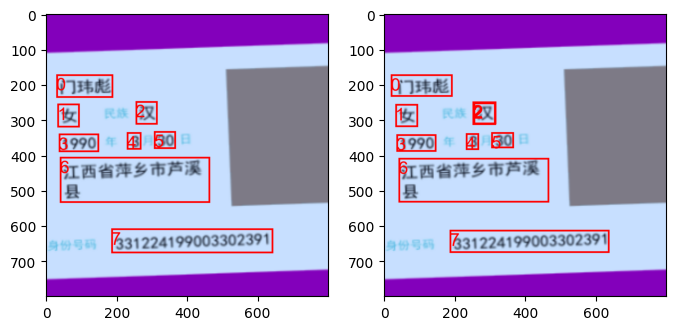

1 500 0.2757834792137146


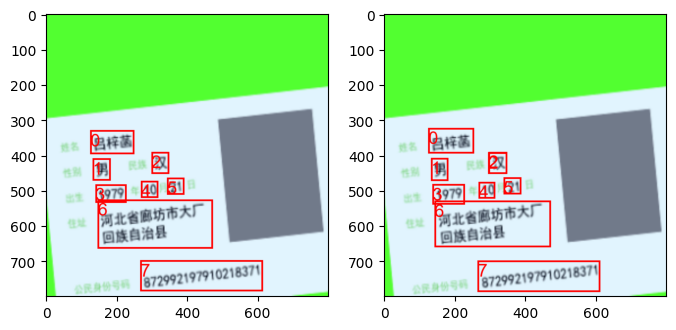

1 1000 0.27773767709732056


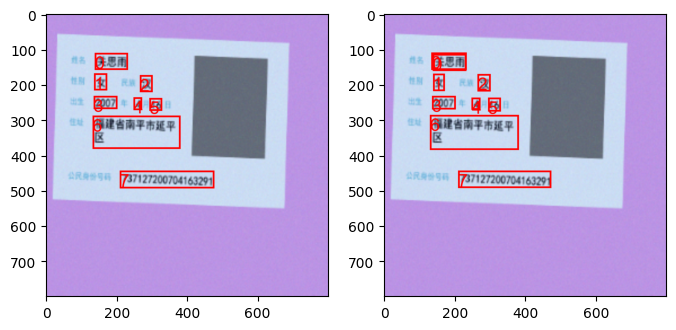

2 0 0.21329975128173828


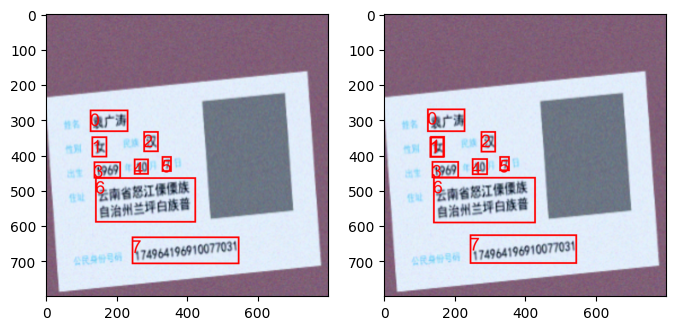

2 500 0.23384638130664825


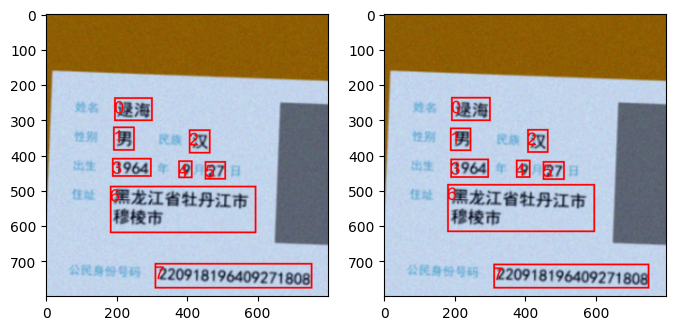

2 1000 0.22380980849266052


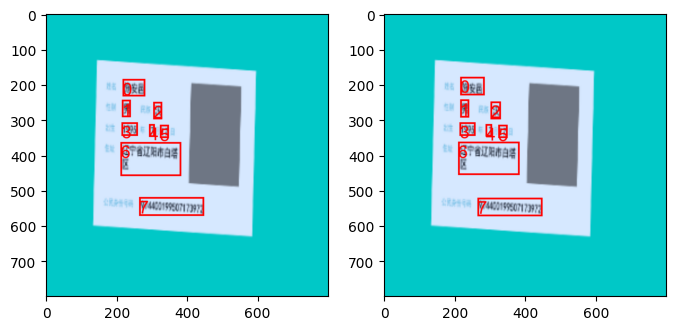

3 0 0.2295929491519928


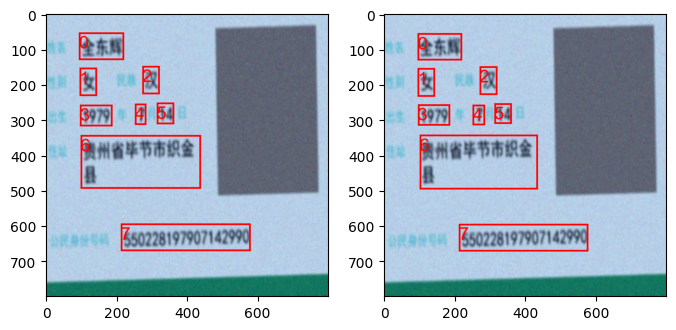

3 500 0.19533413648605347


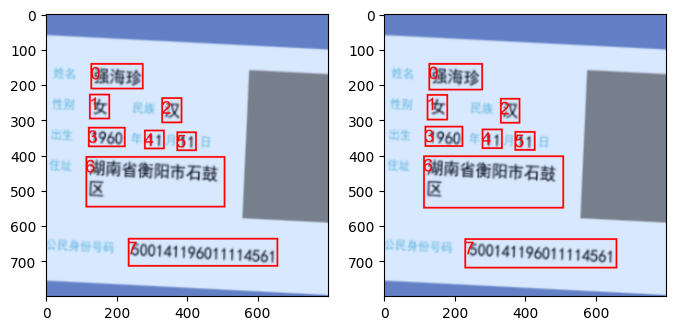

3 1000 0.21503347158432007


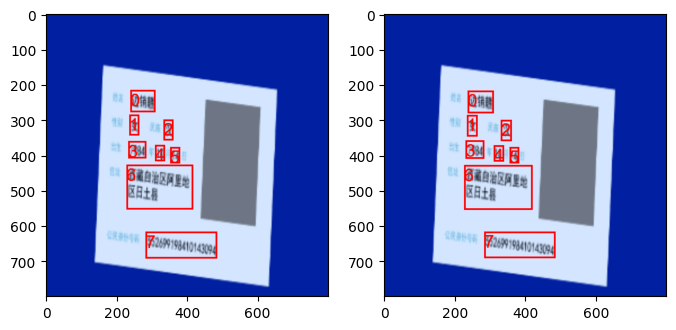

4 0 0.18547981977462769


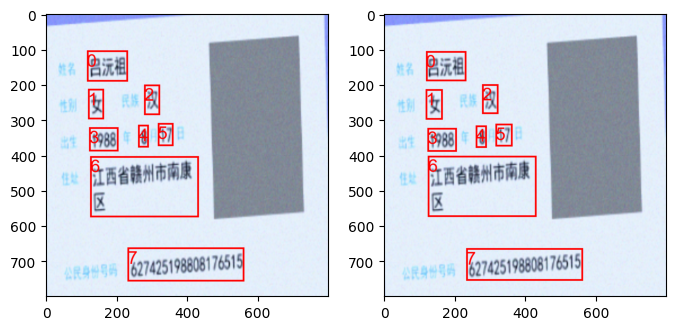

4 500 0.21633027493953705


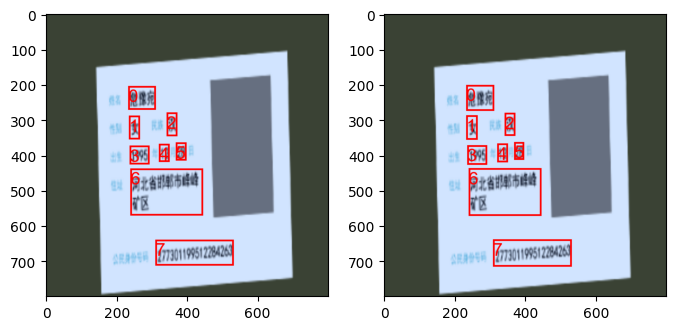

4 1000 0.18837958574295044


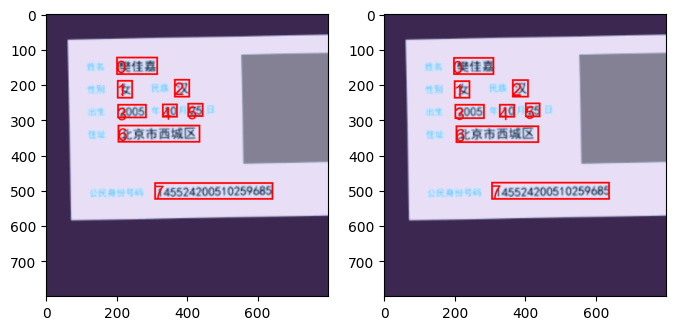

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for epoch in range(5):
    for i, (pixel_values, pixel_mask, class_target, box_target,
            size) in enumerate(loader):
        class_pred, box_pred = model(pixel_values, pixel_mask)

        outputs = {'logits': class_pred, 'pred_boxes': box_pred}
        targets = [{
            'class_labels': c,
            'boxes': b
        } for c, b in zip(class_target, box_target)]
        losses = criterion(outputs, targets)
        loss = 1 * losses['loss_ce'] + 5 * losses['loss_bbox'] + 2 * losses[
            'loss_giou']

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        if i % 500 == 0:
            print(epoch, i, loss.item())
            testi = random.randint(0, 7)
            show(pixel_values[testi], box_target[testi], class_target[testi],
                 box_pred[testi], class_pred[testi], size[testi])

torch.save(model.to('cpu'), 'model/文字定位.model')